## Surface forecast by fitting a hyperbole on the early observations

Here we want to forecast the relative surface by fitting a hyperbole on the first observations and making predictions on the forecasts.
$$f : X_t = f(t) = X_{MAX} \times \frac{t}{t + t_{1/2}} $$

In [1]:
%matplotlib inline
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import scipy.optimize as opt

sns.set_theme()

## Load Data

In [2]:
os.chdir("D:\Documents\STAGE\Anaphase")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

print(data.shape)
data.head()

(495, 13)


,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf
idx,,,,,,,,,,,,,
0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000
0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842
0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853
0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912
0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739


## 0. Toy example : Fit example on a true hyperbole function

In [3]:
# generate data
X = np.linspace(0, 50, 8)

def f(x, Vmax=8, Km=2):
    return Vmax * x / (x + Km)

Vmax, Km = 0.7, 25 # realistic parameters : RSlim \approx 0.7 and Km \approx 25 
noise = np.random.randn(X.shape[0])
y = np.array([f(x, Vmax, Km) + noise[i] * 0.05 for i, x in enumerate(X)])

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# ax.set_xlim(-2.5, 52.5)
# ax.set_ylim(-0.1, 0.65)
# ax.plot(X, y, ".")
# ax.set_title("Classical Hyperbole equation")

C:\Users\Hugo\anaconda3\envs\deep_learning.py\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5, 1.0, 'Hyperbole Fit for different train set sizes')

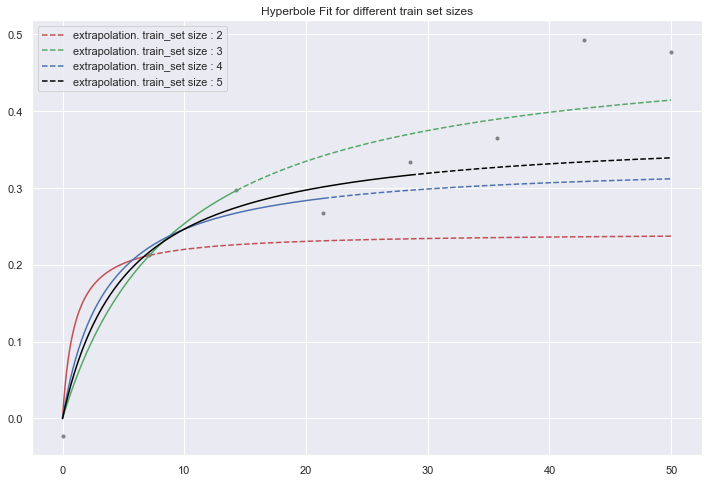

In [7]:
train_size = 4

colors = ["r", "g", "b", "black", "orange", "brown", "pink"]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.scatter(X, y, marker=".", c="grey")

for k in range(2, 6):
    # fit a hyperbole on the early observations
    params, cov = opt.curve_fit(f, X[:k], y[:k])
    xx_under, xx = np.linspace(0, X[k-1], 250), np.linspace(X[k-1], 50, 500)
    ax.plot(xx_under, f(xx_under, Vmax=params[0], Km=params[1]), c=colors[k - 2])
    ax.plot(xx, f(xx, Vmax=params[0], Km=params[1]), "--", c=colors[k - 2], label=f"extrapolation. train_set size : {k}")
ax.legend()
ax.set_title("Hyperbole Fit for different train set sizes")

## 1. On a real trajectory

### 1.1 Prediction on a single trajectory

(9,)


C:\Users\Hugo\anaconda3\envs\deep_learning.py\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5, 1.0, 'Hyperbole Fit for different train set sizes')

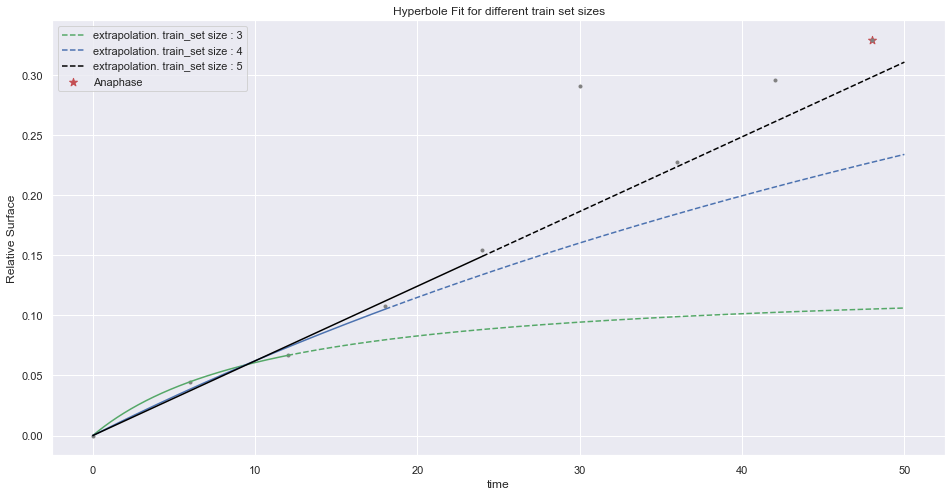

In [15]:
trajectory = data.loc[20]

colors = ["r", "g", "b", "black", "orange", "brown", "pink"]

X, y = trajectory["time"].values, trajectory["relat_surf"].values

print(X.shape)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(X, y, ".", c="grey")

for k in range(3, 6):
    # fit a hyperbole on the early observations
    params, cov = opt.curve_fit(f, X[1:k], y[1:k])
    xx_under, xx = np.linspace(0, X[k-1], 250), np.linspace(X[k-1], 50, 500)
    ax.plot(xx_under, f(xx_under, Vmax=params[0], Km=params[1]), c=colors[k - 2])
    ax.plot(xx, f(xx, Vmax=params[0], Km=params[1]), "--", c=colors[k - 2], label=f"extrapolation. train_set size : {k}")
ax.scatter(trajectory[trajectory["anaphase"]]["time"], trajectory[trajectory["anaphase"]]["relat_surf"], c="r", marker="*", s=70, label="Anaphase")
ax.legend()
ax.set_ylabel("Relative Surface")
ax.set_xlabel("time")
ax.set_title("Hyperbole Fit for different train set sizes")

### 1.2 Evaluate goodness of fit for all trajectories, given the training sample size

The goodness of fit is computed using the clasical RMSE.

In [11]:
for k in range(3, 6):
    # fit a hyperbole on the early observations
    losses = []
    for idx in data.index.unique():
        X, y = data.loc[idx]["time"], data.loc[idx]["relat_surf"]
        params, cov = opt.curve_fit(f, X[1:k], y[1:k], maxfev=1500)
        predictions = f(X, Vmax=params[0], Km=params[1])
        losses.append((y - predictions).sum())
    losses = np.array(losses)
    print(f"RMSE for training length {k} : {np.sqrt(losses.mean())}")

C:\Users\Hugo\anaconda3\envs\deep_learning.py\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


RMSE for training length 3 : 0.49577898732845516
RMSE for training length 4 : 0.3065202256567887
RMSE for training length 5 : 0.13223496429998388


## 2. Predict next anaphase time with a constant threshold on the RS

We fit a hyperbole on the first 2/3/4 observations, forecast the future values of the relative surface and finally predict that the anaphase will occur when the forecast reaches a predicted relative surface of 0.4/0.5.

In [86]:
losses = []
for idx in data.index.unique()[:]:
    traj = data.loc[idx]
    X, y = traj["time"].values,  traj["relat_surf"].values
    
    early_observations = 4
    params, cov = opt.curve_fit(f, X[:early_observations], y[:early_observations], maxfev=1500)
    
    future_time_points = np.linspace(X[early_observations-1] + 0.1, (X[early_observations-1] + 0.1) * 2, 500)
    forecasts =  np.array([f(x, Vmax=params[0], Km=params[1]) for x in future_time_points])
    
#     fig, ax = plt.subplots(1, 1)
    try:
        greater_than_thresh_idx = np.nonzero(forecasts > 0.55)[0][0]
        predicted_anaph_time = future_time_points[greater_than_thresh_idx]
        losses.append((traj["time_to_anaphase"].values[0] - (predicted_anaph_time - X[0])) ** 2)
#         ax.scatter(future_time_points[greater_than_thresh_idx], forecasts[greater_than_thresh_idx], c="black", s=50, marker="+")
    except:
        losses.append((traj["time_to_anaphase"].values[0] - (40 - X[0])) ** 2)  # if the prediction isn't realistic: predict the mean value
#         ax.scatter(40, 0.4, c="black", s=100, marker="+")
#     ax.scatter(X, y, c="b")
#     ax.scatter(traj[traj["anaphase"]]["time"], traj[traj["anaphase"]]["relat_surf"], marker="*", c="r", s=150)
#     ax.plot(future_time_points, forecasts, "--", c='r')
    
losses = np.array(losses)
print(f"RMSE with threshold at 0.4 : {np.sqrt(losses.mean())}")

RMSE with threshold at 0.4 : 7.056204408422437


## 3. TTA regression based on the forecast